Load the required packages

In [2]:
library(ncdf4)
library(viridis)
library(fields)
library(rstan)
options(mc.cores = parallel::detectCores())

Load the netcdf file

In [4]:
nc <- nc_open('data/SeaFlow_SizeDist_regrid-15-5.nc')

Organize the data for R

In [6]:
data             <- list()
data$w_obs       <- ncvar_get(nc,'w_obs')
data$PAR         <- ncvar_get(nc,'PAR')
data$m           <- ncvar_get(nc,'m')
data$delta_v_inv <- ncvar_get(nc,'delta_v_inv')
data$v_min       <- ncvar_get(nc,'v_min')
data$time        <- ncvar_get(nc,'time')

data$dt     <- 20
data$nt     <- 2*1440/data$dt
data$nt_obs <- length(data$time)

t                 <- (0:data$nt)*data$dt
data$E            <- approx(data$time,data$PAR,xout=t)$y
data$return_prior <- 0
data$obs          <- t(data$w_obs)
data$t_obs        <- data$time
data$w_ini        <- data$w_obs[1,]

delta_v <- 1/data$delta_v_inv
v       <- data$v_min*2^(0:14*delta_v)

Limit the amount of data we are fitting to

In [7]:
limit_to_numdays <- 2.0
stride_t_obs     <- 20

ind_obs    <- data$t_obs > 3
data$t_obs <- data$t_obs[ind_obs]
data$obs   <- data$obs[,ind_obs]

if(limit_to_numdays > 0){
    thresh     <- limit_to_numdays*1440
    ind_obs    <- data$t_obs < thresh
    data$t_obs <- data$t_obs[ind_obs]
    data$obs   <- data$obs[,ind_obs]

    data$nt    <- thresh/data$dt
    data$E     <- data$E[t < thresh]
}

if(stride_t_obs > 0){
    data$t_obs <- data$t_obs[seq(1,length(data$t_obs),stride_t_obs)]
    data$obs   <- data$obs[,seq(1,ncol(data$obs),stride_t_obs)]
}

data$nt_obs <- dim(data$obs)[2]

Separate training and test data

In [103]:
i_test_1 <- c(rep(0,31),rep(1,15))
i_test_2 <- rbinom(n=46,size=1,p=0.2)
i_test_3 <- c(rep(0,10),rep(1,5),rep(0,10),rep(1,5),rep(0,16))

Make three datasets with different i_test divisions

In [104]:
data_1        <- data
data_1$i_test <- i_test_1
data_2        <- data
data_2$i_test <- i_test_2
data_3        <- data
data_3$i_test <- i_test_3

Visualize the test and training separations

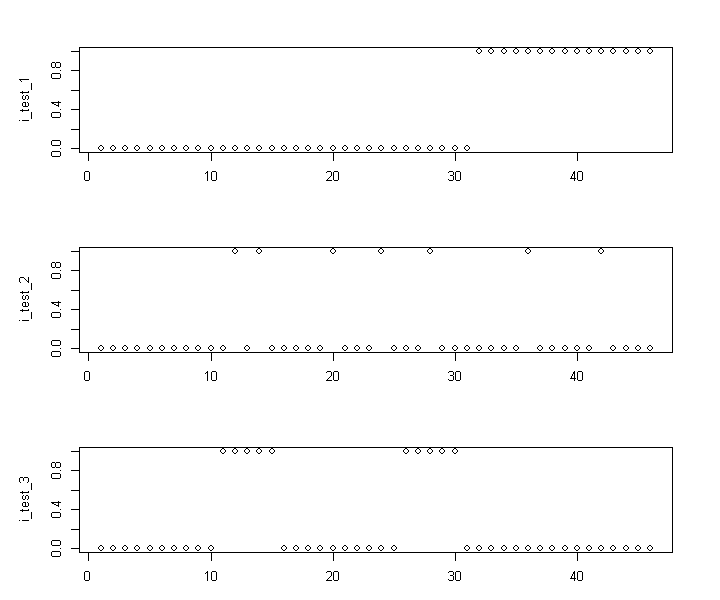

In [105]:
options(repr.plot.width=6, repr.plot.height=5)
par(mfrow=c(3,1),mar=c(3,5,3,3))
plot(i_test_1)
plot(i_test_2)
plot(i_test_3)

In [ ]:
data$i_test = c(rep(0,35),rep(1,11))

The original allometric parameterization follows
$$ \delta(v) = \delta_{max}\frac{v^b}{1 + v^b} $$

Compile the allometric model:

In [34]:
mod_orig <- stan_model('matrixmodel_orig_CV.stan')

The size-specific Gaussian model follows
$$ \delta(v) \sim N(\mu,\sigma^2_{\delta}) $$

Compile the Gaussian model

In [33]:
mod_free <- stan_model('matrixmodel_freedelta_CV.stan')

The sigmoidal model follows
$$ \delta(v) = \delta_{max} \frac{1}{1 + e^{\phi (v-v_0)}} $$

Compile the model:

In [35]:
mod_sig  <- stan_model('matrixmodel_sigmoidaldelta_CV.stan')

The freeest of them all, i.e. no hyper-prior on $\delta(v)$

In [126]:
mod_free_np <- stan_model('matrixmodel_freedelta_no_prior_CV.stan')

Fit the size-specific Gaussian model using the three training/test divisions

In [100]:
mcmc_free_1 <- sampling(mod_free, data=data_1, open_progress=TRUE, chains=4)

In [101]:
mcmc_free_2 <- sampling(mod_free, data=data_2, open_progress=TRUE, chains=4)

In [106]:
mcmc_free_3 <- sampling(mod_free, data=data_3, open_progress=TRUE, chains=4)

In [107]:
post_free_1 <- extract(mcmc_free_1)
post_free_2 <- extract(mcmc_free_2)
post_free_3 <- extract(mcmc_free_3)

In [108]:
summary(mcmc_free_1, pars = c('delta_mu','delta_sigma','delta_max','gamma_max','E_star','sigma','log_like_test'))$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
delta_mu,3.35018532,1.183784e-02,0.826579708,1.80717587,2.75940739,3.3349529,3.9129593,5.0077788,4875.563,0.9996073
delta_sigma,4.29878926,1.700590e-02,0.977481928,2.41389537,3.63251482,4.3013943,4.9585557,6.2742608,3303.835,0.9999067
delta_max[1],0.45252706,2.119528e-03,0.118235064,0.26880110,0.36329423,0.4376103,0.5234443,0.7294423,3111.817,1.0002562
delta_max[2],1.41169676,2.749020e-03,0.168507241,1.09968107,1.30362134,1.4002415,1.5100911,1.7881228,3757.348,0.9998912
delta_max[3],2.02778867,6.253344e-03,0.375390523,1.34549458,1.76654294,2.0218749,2.2678180,2.8047365,3603.645,1.0008940
delta_max[4],2.53298130,8.869765e-03,0.551712197,1.56589674,2.14798346,2.4976383,2.8745143,3.7479971,3869.020,0.9995215
delta_max[5],2.37366557,9.826116e-03,0.587122088,1.33303379,1.96547027,2.3324102,2.7432355,3.6489360,3570.205,0.9998596
delta_max[6],2.69489357,1.580950e-02,0.899818398,1.09109839,2.07386397,2.6572340,3.2413964,4.6034281,3239.466,1.0003248
delta_max[7],6.75145472,3.191691e-02,2.233925250,3.26006995,5.23427421,6.4147165,7.9717136,12.1745038,4898.865,0.9997344
delta_max[8],9.00609414,5.078676e-02,3.311099050,3.37917242,6.64929064,8.6706856,11.0119298,16.3616369,4250.532,0.9997726


Fit the original model with allometric parameterization

In [116]:
mcmc_orig_1 <- sampling(mod_orig, data=data_1, open_progress=TRUE,chains=4)

In [112]:
mcmc_orig_2 <- sampling(mod_orig, data=data_2, open_progress=TRUE,chains=4)

In [114]:
mcmc_orig_3 <- sampling(mod_orig, data=data_3, open_progress=TRUE,chains=4)

In [117]:
post_orig_1 <- extract(mcmc_orig_1)
post_orig_2 <- extract(mcmc_orig_2)
post_orig_3 <- extract(mcmc_orig_3)

In [118]:
summary(mcmc_orig_1, pars = c('delta_max','b','gamma_max','E_star','sigma','log_like_test'))$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
delta_max,64.6886981,4.753866e-01,6.645829e+00,47.7362971,61.3630075,66.5201923,69.8524515,71.8288402,195.4359,1.023319
b,1.1595689,3.000663e-03,4.886004e-02,1.0577204,1.1288089,1.1617107,1.1914669,1.2574617,265.1387,1.015832
gamma_max,23.6960940,4.086670e-01,5.811225e+00,13.0397328,19.3993955,23.4310455,27.7354330,35.1900962,202.2070,1.015930
E_star,3238.2910899,6.924246e+01,9.253136e+02,1369.9421060,2590.7447469,3249.7657954,3920.9799800,4875.4844773,178.5800,1.016718
sigma,0.1144534,3.878961e-04,6.528574e-03,0.1024888,0.1101295,0.1139212,0.1187898,0.1275678,283.2735,1.020363
log_like_test,-3.4947860,1.780454e-02,2.945633e-01,-4.1045650,-3.6748164,-3.4908526,-3.2918130,-2.9718214,273.7132,1.019363


Fit the sigmoidal model

In [119]:
mcmc_sig_1 <- sampling(mod_sig, data=data_1, open_progress=TRUE,chains=4)

In [120]:
mcmc_sig_2 <- sampling(mod_sig, data=data_2, open_progress=TRUE, chains=4)

In [121]:
mcmc_sig_3 <- sampling(mod_sig, data=data_3, open_progress=TRUE, chains=4)

In [123]:
post_sig_1 <- extract(mcmc_sig_1)
post_sig_2 <- extract(mcmc_sig_2)
post_sig_3 <- extract(mcmc_sig_3)

In [39]:
summary(mcmc_sig_`, pars = c('delta_max','gamma_max','sig_offset','sig_steepness','E_star','sigma','log_like_test'))$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
delta_max,4.50167054,0.0334553422,1.213787127,2.64042639,3.5991137,4.32974996,5.23480181,7.26232037,1316.298,1.0008448
gamma_max,26.72548011,0.0569676585,2.737458296,21.35978443,24.8880546,26.75864897,28.63396795,31.91400202,2309.076,0.9997962
sig_offset,0.03872078,0.0001225914,0.004457953,0.03231439,0.0353256,0.03794459,0.04133968,0.04909522,1322.365,1.0016030
sig_steepness,167.01025611,1.6510576874,61.676496390,89.98414593,123.0551677,152.87322547,196.13991822,323.65023560,1395.452,1.0014607
E_star,2999.52401376,0.1759863705,9.598416413,2980.55028938,2993.0989441,2999.54070144,3005.80726015,3018.75066612,2974.686,1.0005712
sigma,0.10900412,0.0001281812,0.006148930,0.09757286,0.1047865,0.10877725,0.11306423,0.12183388,2301.178,0.9997874
log_like_test,-1.98075843,0.0048315830,0.214670462,-2.41847315,-2.1241563,-1.97413264,-1.82421925,-1.60299161,1974.084,1.0023072


In [127]:
mcmc_free_np_1 <- sampling(mod_free_np,data=data_1,open_progress=TRUE,chains=4)

Warning message:
"There were 3976 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Warning message:
"The largest R-hat is 1.14, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat"Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess"Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess"

In [130]:
summary(mcmc_free_np_1, pars = c('delta_max','gamma_max','E_star','sigma','log_like_test'))$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
delta_max[1],0.49041705,0.0152267289,0.1278405,0.28112174,0.40112567,0.47198762,0.5693099,0.7851965,70.48939,1.062780
delta_max[2],1.43261235,0.0227910704,0.1725666,1.10493452,1.32298437,1.42346399,1.5335221,1.8134249,57.33027,1.093713
delta_max[3],2.11613892,0.0357090347,0.3537062,1.49889894,1.84438482,2.09572950,2.3513912,2.8363784,98.11360,1.062510
delta_max[4],2.51266495,0.0637658881,0.5627990,1.51735693,2.12750671,2.48669912,2.8021366,3.8880896,77.89864,1.060467
delta_max[5],2.49754011,0.0684172929,0.6149830,1.44780533,2.05115121,2.45227387,2.8610577,3.8694195,80.79686,1.070513
delta_max[6],2.99757407,0.1152835735,0.9112443,1.38221666,2.38370120,2.95797211,3.5326029,4.9072125,62.47910,1.062903
delta_max[7],8.25417316,0.3641958925,4.4205864,3.49873296,5.78481341,7.17596386,9.5548662,17.7085098,147.32949,1.024472
delta_max[8],36.71871482,1.7061175556,18.8190535,7.68255157,20.55505089,34.73064925,53.0719781,69.9089628,121.66836,1.036496
delta_max[9],34.90454388,1.9274684491,21.0586032,1.71690865,16.25614741,33.66238186,53.6146716,69.8509445,119.36708,1.022675
delta_max[10],34.39360782,1.9862962061,21.6926674,0.90657942,15.62247282,33.23783384,52.8026805,70.5294538,119.27183,1.029257


In [135]:
mcmc_free_np_2 <- sampling(mod_free_np, data=data_2, open_progress=TRUE, chains=4)

In [142]:
mcmc_free_np_3 <- sampling(mod_free_np, data=data_3, open_progress=TRUE, chains=4)

In [143]:
post_free_np_1 <- extract(mcmc_free_np_1)
post_free_np_2 <- extract(mcmc_free_np_2)
post_free_np_3 <- extract(mcmc_free_np_3)

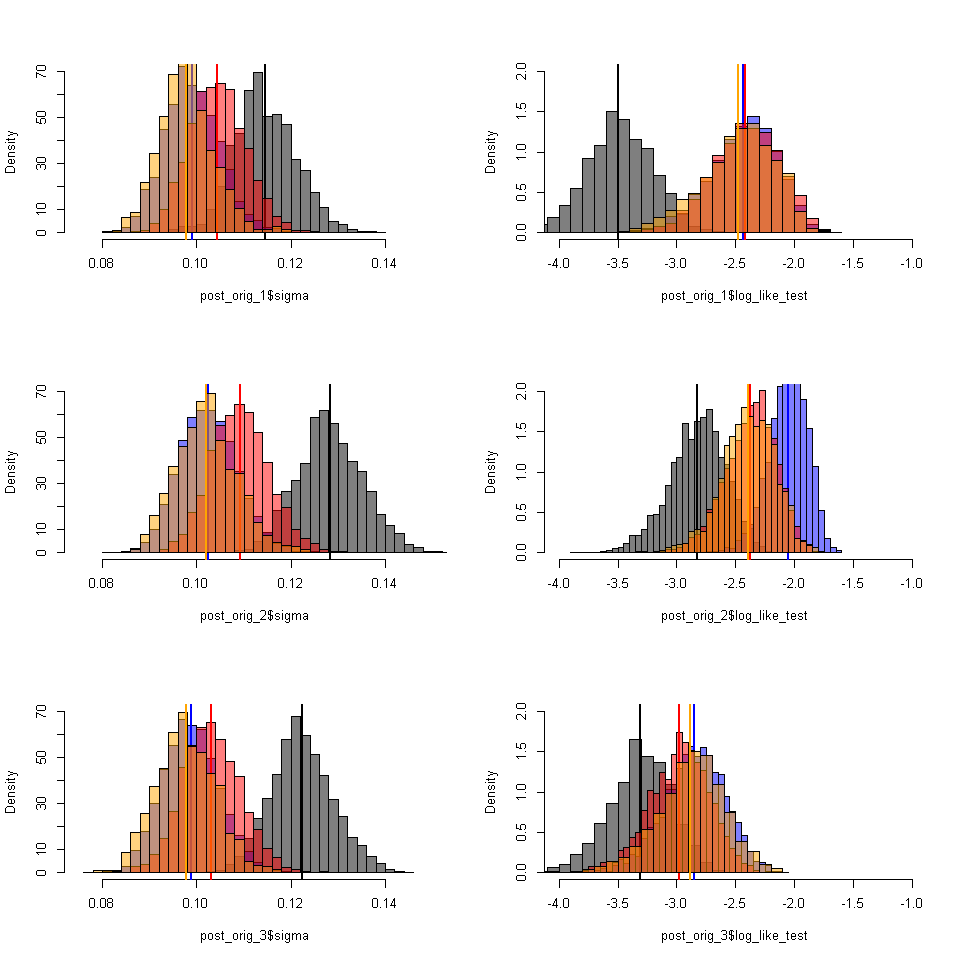

In [144]:
options(repr.plot.width=8, repr.plot.height=8)
par(mfrow=c(3,2))

##--i_test_1---####################
hist(post_orig_1$sigma,main='',col=adjustcolor('black',alpha.f=0.5),xlim=c(0.075,0.15),freq=FALSE,ylim=c(0,70),breaks=25)
    abline(v=mean(post_orig_1$sigma),lwd=2)
hist(post_free_1$sigma,main='',col=adjustcolor('blue',alpha.f=0.5),freq=FALSE,add=TRUE,breaks=25)
    abline(v=mean(post_free_1$sigma),lwd=2,col='blue')
hist(post_sig_1$sigma,main='',col=adjustcolor('red',alpha.f=0.5),freq=FALSE,add=TRUE,breaks=25)
    abline(v=mean(post_sig_1$sigma),lwd=2,col='red')
hist(post_free_np_1$sigma,main='',col=adjustcolor('orange',alpha.f=0.5),freq=FALSE,add=TRUE,breaks=25)
    abline(v=mean(post_free_np_1$sigma),lwd=2,col='orange')

hist(post_orig_1$log_like_test,main='',col=adjustcolor('black',alpha.f=0.5),freq=FALSE,breaks=30,xlim=c(-4,-1),ylim=c(0,2))
    abline(v=mean(post_orig_1$log_like_test),lwd=2)
hist(post_free_1$log_like_test,main='',col=adjustcolor('blue',alpha.f=0.5),freq=FALSE,breaks=30,add=TRUE)
    abline(v=mean(post_free_1$log_like_test),lwd=2,col='blue')
hist(post_sig_1$log_like_test,main='',col=adjustcolor('red',alpha.f=0.5),freq=FALSE,breaks=30,add=TRUE)
    abline(v=mean(post_sig_1$log_like_test),lwd=2,col='red')
hist(post_free_np_1$log_like_test,main='',col=adjustcolor('orange',alpha.f=0.5),freq=FALSE,breaks=30,add=TRUE)
    abline(v=mean(post_free_np_1$log_like_test),lwd=2,col='orange')

##--i_test_2---####################
hist(post_orig_2$sigma,main='',col=adjustcolor('black',alpha.f=0.5),xlim=c(0.075,0.15),freq=FALSE,ylim=c(0,70),breaks=25)
    abline(v=mean(post_orig_2$sigma),lwd=2)
hist(post_free_2$sigma,main='',col=adjustcolor('blue',alpha.f=0.5),freq=FALSE,add=TRUE,breaks=25)
    abline(v=mean(post_free_2$sigma),lwd=2,col='blue')
hist(post_sig_2$sigma,main='',col=adjustcolor('red',alpha.f=0.5),freq=FALSE,add=TRUE,breaks=25)
    abline(v=mean(post_sig_2$sigma),lwd=2,col='red')
hist(post_free_np_2$sigma,main='',col=adjustcolor('orange',alpha.f=0.5),freq=FALSE,add=TRUE,breaks=25)
    abline(v=mean(post_free_np_2$sigma),lwd=2,col='orange')

hist(post_orig_2$log_like_test,main='',col=adjustcolor('black',alpha.f=0.5),freq=FALSE,breaks=30,xlim=c(-4,-1),ylim=c(0,2))
    abline(v=mean(post_orig_2$log_like_test),lwd=2)
hist(post_free_2$log_like_test,main='',col=adjustcolor('blue',alpha.f=0.5),freq=FALSE,breaks=30,add=TRUE)
    abline(v=mean(post_free_2$log_like_test),lwd=2,col='blue')
hist(post_sig_2$log_like_test,main='',col=adjustcolor('red',alpha.f=0.5),freq=FALSE,breaks=30,add=TRUE)
    abline(v=mean(post_sig_2$log_like_test),lwd=2,col='red')
hist(post_free_np_2$log_like_test,main='',col=adjustcolor('orange',alpha.f=0.5),freq=FALSE,breaks=30,add=TRUE)
    abline(v=mean(post_free_np_2$log_like_test),lwd=2,col='orange')

##--i_test_3---####################
hist(post_orig_3$sigma,main='',col=adjustcolor('black',alpha.f=0.5),xlim=c(0.075,0.15),freq=FALSE,ylim=c(0,70),breaks=25)
    abline(v=mean(post_orig_3$sigma),lwd=2)
hist(post_free_3$sigma,main='',col=adjustcolor('blue',alpha.f=0.5),freq=FALSE,add=TRUE,breaks=25)
    abline(v=mean(post_free_3$sigma),lwd=2,col='blue')
hist(post_sig_3$sigma,main='',col=adjustcolor('red',alpha.f=0.5),freq=FALSE,add=TRUE,breaks=25)
    abline(v=mean(post_sig_3$sigma),lwd=2,col='red')
hist(post_free_np_3$sigma,main='',col=adjustcolor('orange',alpha.f=0.5),freq=FALSE,add=TRUE,breaks=25)
    abline(v=mean(post_free_np_3$sigma),lwd=2,col='orange')

hist(post_orig_3$log_like_test,main='',col=adjustcolor('black',alpha.f=0.5),freq=FALSE,breaks=30,xlim=c(-4,-1),ylim=c(0,2))
    abline(v=mean(post_orig_3$log_like_test),lwd=2)
hist(post_free_3$log_like_test,main='',col=adjustcolor('blue',alpha.f=0.5),freq=FALSE,breaks=30,add=TRUE)
    abline(v=mean(post_free_3$log_like_test),lwd=2,col='blue')
hist(post_sig_3$log_like_test,main='',col=adjustcolor('red',alpha.f=0.5),freq=FALSE,breaks=30,add=TRUE)
    abline(v=mean(post_sig_3$log_like_test),lwd=2,col='red')
hist(post_free_np_3$log_like_test,main='',col=adjustcolor('orange',alpha.f=0.5),freq=FALSE,breaks=30,add=TRUE)
    abline(v=mean(post_free_np_3$log_like_test),lwd=2,col='orange')
